<a href="https://colab.research.google.com/github/lanbowen23/CSCE636/blob/master/HW3_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Using pretrained VGG16 model

level of generality(reusability) of the representations extracted decrease as layer deepen. Layers that come earlier extract generic infomation like visual edges, colors, textures


In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [2]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### Extract features from these images simply by calling the `predict` method of the `conv_base` model

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator


base_dir = 'cats_and_dogs_small/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### flatten them to fit into densely-connected classifier

In [0]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

### Define densely-connected classifier and train it on the data we just recorded

In [5]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 549us/step - loss: 0.6266 - acc: 0.6505 - val_loss: 0.4342 - val_acc: 0.8390
Epoch 2/30
2000/2000 [==============================] - 1s 344us/step - loss: 0.4347 - acc: 0.8140 - val_loss: 0.3560 - val_acc: 0.8640
Epoch 3/30
2000/2000 [==============================] - 1s 340us/step - loss: 0.3688 - acc: 0.8435 - val_loss: 0.3277 - val_acc: 0.8670
Epoch 4/30
2000/2000 [==============================] - 1s 349us/step - loss: 0.3258 - acc: 0.8640 - val_loss: 0.2983 - val_acc: 0.8810
Epoch 5/30
2000/2000 [==============================] - 1s 339us/step - loss: 0.2836 - acc: 0.8840 - val_loss: 0.2780 - val_acc: 0.8950
Epoch 6/30
2000/2000 [==============================] - 1s 337us/step - loss: 0.2658 - acc: 0.8875 - val_loss

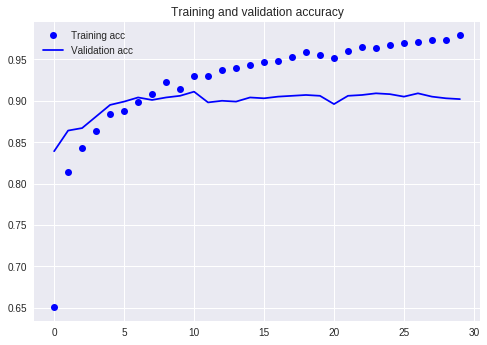

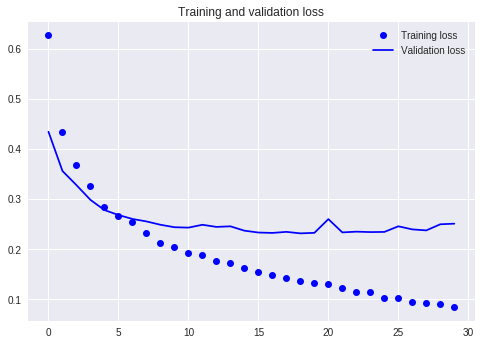

In [6]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Second Method: add a layer to the conv_base

In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


## It's very important to freeze the convolutional base

In [0]:
conv_base.trainable = False

In [10]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 27s - loss: 0.5818 - acc: 0.7015 - val_loss: 0.4527 - val_acc: 0.8180
Epoch 2/30
 - 25s - loss: 0.4783 - acc: 0.7995 - val_loss: 0.3671 - val_acc: 0.8640
Epoch 3/30
 - 24s - loss: 0.4397 - acc: 0.8065 - val_loss: 0.3308 - val_acc: 0.8720
Epoch 4/30
 - 25s - loss: 0.3892 - acc: 0.8255 - val_loss: 0.3071 - val_acc: 0.8790
Epoch 5/30
 - 24s - loss: 0.3784 - acc: 0.8440 - val_loss: 0.2945 - val_acc: 0.8850
Epoch 6/30
 - 24s - loss: 0.3678 - acc: 0.8390 - val_loss: 0.2981 - val_acc: 0.8710
Epoch 7/30
 - 24s - loss: 0.3611 - acc: 0.8385 - val_loss: 0.2751 - val_acc: 0.8900
Epoch 8/30
 - 24s - loss: 0.3488 - acc: 0.8445 - val_loss: 0.2792 - val_acc: 0.8850
Epoch 9/30
 - 24s - loss: 0.3432 - acc: 0.8500 - val_loss: 0.2735 - val_acc: 0.8850
Epoch 10/30
 - 24s - loss: 0.3339 - acc: 0.8570 - val_loss: 0.2611 - val_acc: 0.8910
Epoch 11/30
 - 24s - loss: 0.3442 - acc: 0.8375 - val_loss: 0.2626 - val_ac

In [0]:
model.save('cats_and_dogs_small_3.h5')

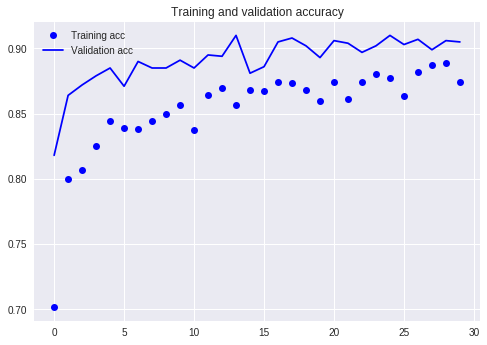

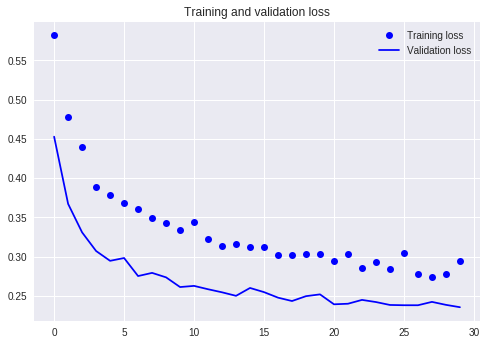

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Fine-tuning

Fine-tuning consists in unfreezing a few of the top layers of a frozen model base used of feature extraction, and jointly training bothe the newly added part of the model and these top layers. Only the more abstract representations of the model being reused, like get the notion of eye, nose.

* 1) Add your custom network on top of an already trained base network.
* 2) Freeze the base network.
* 3) Train the part you added.
* 4) Unfreeze some layers in the base network.
* 5) Jointly train both these layers and the part you added.

We will fine-tune `block5_conv1`, `block5_conv2`, `block5_conv3`

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

#### use lower learning rate

In [14]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 28s 283ms/step - loss: 0.2879 - acc: 0.8725 - val_loss: 0.2348 - val_acc: 0.9040
Epoch 2/100
100/100 [==============================] - 25s 255ms/step - loss: 0.2676 - acc: 0.8895 - val_loss: 0.2152 - val_acc: 0.9190
Epoch 3/100
100/100 [==============================] - 25s 254ms/step - loss: 0.2396 - acc: 0.9010 - val_loss: 0.2047 - val_acc: 0.9240
Epoch 4/100
100/100 [==============================] - 26s 257ms/step - loss: 0.2223 - acc: 0.9115 - val_loss: 0.2009 - val_acc: 0.9160
Epoch 5/100
100/100 [==============================] - 26s 260ms/step - loss: 0.2030 - acc: 0.9195 - val_loss: 0.2267 - val_acc: 0.9150
Epoch 6/100
100/100 [==============================] - 26s 264ms/step - loss: 0.2058 - acc: 0.9150 - val_loss: 0.1762 - val_acc: 0.9280
Epoch 7/100
100/100 [==============================] - 27s 266ms/step - loss: 0.1770 - acc: 0.9245 - val_loss: 0.1879 - val_acc: 0.9310
Epoch 8/100
100/100 [===========================

In [0]:
model.save('cats_and_dogs_small_4.h5')

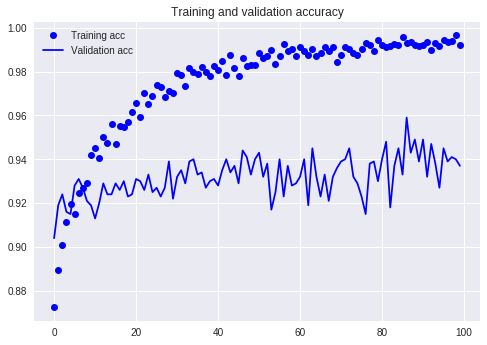

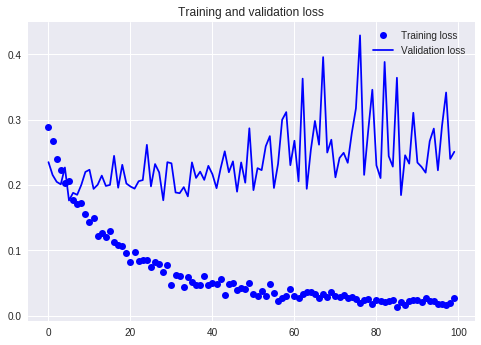

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### These curves look very noisy. To make them more readable, we can smooth them by replacing every loss and accuracy with exponential moving 
averages of these quantities. Here's a trivial utility function to do this:

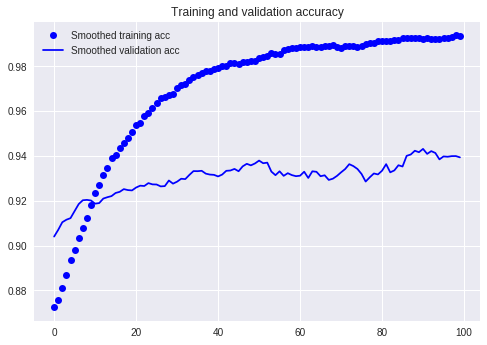

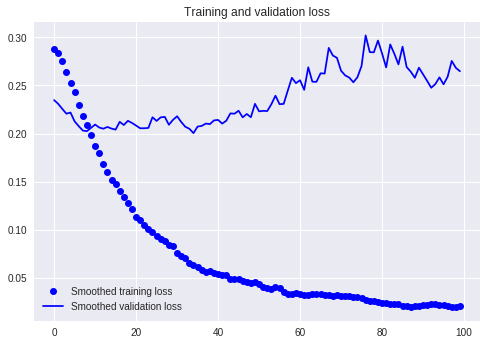

In [17]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### test model on the test data

In [18]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9339999890327454
